In [ ]:
import torch
import copy

from typing import Tuple
from enum import Enum
import random
from abc import ABC, abstractmethod
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.cm as cm
import time, threading

## Environment Setup
### Utility Classes
#### `Coordinate` class  
Contains x and y values to represent 2D coordinates.

In [ ]:
# generated by ChatGPT
class Coordinate:
    def __init__(self, x: int, y: int):
        self.x = x
        self.y = y

    def __add__(self, other: 'Coordinate') -> 'Coordinate':
        if isinstance(other, Coordinate):
            return Coordinate(self.x + other.x, self.y + other.y)
        return NotImplemented

    def __sub__(self, other: 'Coordinate') -> 'Coordinate':
        if isinstance(other, Coordinate):
            return Coordinate(self.x - other.x, self.y - other.y)
        return NotImplemented

    def __repr__(self) -> str:
        return f"Coordinate(x={self.x}, y={self.y})"

    def __str__(self) -> str:
        return f"Coordinate({self.x}, {self.y})"

    def __eq__(self, other: 'Coordinate') -> bool:
        if isinstance(other, Coordinate):
            return self.x == other.x and self.y == other.y
        return False

    def to_tuple(self) -> Tuple[int, int]:
        return (self.x, self.y)

    @staticmethod
    def from_tuple(coord: Tuple[int, int]) -> 'Coordinate':
        return Coordinate(coord[0], coord[1])


### Enums
#### `Item` Enum
Represents whether an item is in the agent's possession. This was created instead of using a boolean to help with state management and debugging.

#### `Reward` Enum
Represents rewards and their value.

#### `Action` Enum
Cardinal Directions. The `to_coordinate()` method converts the action into a 1 distance Coordinate going in that direction.

In [ ]:
class Item(Enum):
    NOT_IN_POSSESSION = 0
    IN_POSSESSION = 1

class Reward(Enum):

    EXCHANGE_KEY = 20
    DROPPED_OFF_ITEM = 10
    WANDERED = -5
    BUMPED = -25


class Action(Enum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3

    def to_coordinate(self):
        if self == Action.NORTH:
            return Coordinate(0,-1)
        elif self == Action.EAST:
            return Coordinate(1,0)
        elif self == Action.SOUTH:
            return Coordinate(0,1)
        else:
            return Coordinate(-1,0)

    @staticmethod
    def generate_random_action():
        return random.choice(list(Action))

### ABCs
#### `Agent`
An agent that knows its location and the world it's in.

In [ ]:
class Agent(ABC):
    def __init__(self, starting_coord: Coordinate):
        self.location = starting_coord
        self.objective_completed = False
        self.world = None
        self.bumped_wall = False

    def move(self, action: Action):
        new_location = self.location + action.to_coordinate()
        if self.within_world_boundary(new_location):
            self.location = new_location
        else:
            self.bumped_wall = True

    def spawn(self, location: Coordinate):
        self.location = location

    def within_world_boundary(self, location: Coordinate) -> bool:
            return self.world.valid_location(location)

    def has_completed_objective(self) -> bool:
        return self.objective_completed

    def observe_world(self, world: 'SingleAgentGridWorld' = None) -> None:
        if world:
            self.world = world

    @abstractmethod
    def reset(self) -> None:
        pass

    @abstractmethod
    def get_action(self) -> Action:
        pass

    @abstractmethod
    def execute_action(self, action: Action) -> None:
        pass

    @abstractmethod
    def activate_testing_mode(self):
        pass

    @abstractmethod
    def activate_training_mode(self):
        pass

#### `SingleAgentGridWorld`
A `nxn` grid world with a single agent in it.

In [ ]:
class SingleAgentGridWorld(ABC):
    def __init__(self, agent: Agent, n: int):
        self.n = n
        self.agent = agent
        self.blocked_locations: List[Coordinate] = []

    def valid_location(self, coord: Coordinate) -> bool:
        x, y = coord.to_tuple()
        not_blocked_cell = coord not in self.blocked_locations
        in_boundary = (x >= 0 and x < self.n) and (y >= 0 and y < self.n)  # within grid world dimensions
        return not_blocked_cell and in_boundary

    @staticmethod
    def generate_random_coord(n: int) -> Coordinate:
        rows = n
        cols = n
        x = np.random.randint(0,cols)
        y = np.random.randint(0,rows)
        return Coordinate(x, y)

    @abstractmethod
    def has_agents_completed_objective(self) -> bool:
        pass

    @abstractmethod
    def reset(self) -> None:
        pass

    @abstractmethod
    def activate_testing_mode(self):
        pass

    @abstractmethod
    def activate_training_mode(self):
        pass


## Deep Q Learning Algorithm

The function "prepare_torch" needs to be called once and only once at the start of your program to initialise PyTorch and generate the two Q-networks. It returns the target model (for testing).

The function "update_target" copies the state of the prediction network to the target network. You need to use this in regular intervals.

The function "get_qvals" returns a numpy list of qvals for the state given by the argument _based on the prediction network_.

The function "get_maxQ" returns the maximum q-value for the state given by the argument _based on the target network_.

The function "train_one_step_new" performs a single training step. It returns the current loss (only needed for debugging purposes). Its parameters are three parallel lists: a minibatch of states, a minibatch of actions, a minibatch of the corresponding TD targets and the discount factor.

In [ ]:
from collections import deque


class DeepQLearning():
    def __init__(self,
                 statespace_size: int,
                 learning_rate: float = 0.997,
                 starting_epsilon: float = 1.0,
                 epsilon_decay_factor: float = 0.997,
                 min_epsilon: float = 0.1,
                 replay_buffer_size: int = 1000,
                 batch_size: int = 200,
                 network_copy_freq: int = 500):
        self.statespace_size = statespace_size
        self.learning_rate = learning_rate
        self.epsilon = starting_epsilon
        self.epsilon_decay_factor = epsilon_decay_factor
        self.min_epsilon = min_epsilon
        self.replay_buffer_size = replay_buffer_size
        self.batch_size = batch_size
        self.network_copy_freq = network_copy_freq
        self.model = None
        self.model2 = None
        self.optimizer = None
        self.loss_fn = None
        self.replay_buffer = deque(maxlen=self.replay_buffer_size)
        self.use_epsilon = True
        self.loss_history = []

    def get_action(self, state) -> Action:
        if self.use_epsilon and random.random() < self.epsilon:
            return Action.generate_random_action()
        else:
            return Action(self.get_maxQIndex(state).item())

    def ignore_epsilon(self) -> None:
        self.use_epsilon = False

    def acknowledge_epsilon(self) -> None:
        self.use_epsilon = True

    def addToReplay(self, current_state, action, reward, next_state, done) -> None:
        self.replay_buffer.append((current_state, action, reward, next_state, done))

    def decay_epsilon(self) -> None:
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay_factor)

    def enough_experiences_in_buffer(self):
        return len(self.replay_buffer) >= self.batch_size

    def prepare_torch(self):
        l1 = self.statespace_size
        l2 = 150
        l3 = 100
        l4 = 4
        self.model = torch.nn.Sequential(
            torch.nn.Linear(l1, l2),
            torch.nn.ReLU(),
            torch.nn.Linear(l2, l3),
            torch.nn.ReLU(),
            torch.nn.Linear(l3,l4))
        self.model2 = copy.deepcopy(self.model)  # target model
        self.model2.load_state_dict(self.model.state_dict())
        self.loss_fn = torch.nn.MSELoss()
        learning_rate = 1e-3
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        return self.model2

    def update_target(self):
        # update parameter of target model
        self.model2.load_state_dict(self.model.state_dict())

    def get_qvals(self, state):
        # return Qval from prediction model
        state1 = torch.from_numpy(state).float()
        qvals_torch = self.model(state1)
        qvals = qvals_torch.data.numpy()
        return qvals

    def get_qvals2(self, state):
        # return Qval from target model
        state1 = torch.from_numpy(state).float()
        qvals_torch = self.model2(state1)
        qvals = qvals_torch.data.numpy()
        return qvals

    def get_maxQ(self, s):
        # return the maximum Q value from target model
        return torch.max(self.model2(torch.from_numpy(s).float())).float()

    def get_maxQIndex(self, s):
        # return the index of the maximum Qvalue from target model
        return torch.argmax(self.model2(torch.from_numpy(s).float()))

    def train_one_step(self, states, actions, targets, gamma = 0.95):
        # pass to this function: state1_batch, action_batch, TD_batch
        global model, model2
        state1_batch = torch.cat([torch.from_numpy(s).float() for s in states])
        action_batch = torch.Tensor(actions)
        Q1 = self.model(state1_batch)
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
        Y = torch.tensor(targets)
        loss = self.loss_fn(X, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()


    def learn(self, steps: int, gamma = 0.95):
        # perform forward propagation for a random minibatch sampled from replay_buffer
        mini_batch = random.sample(self.replay_buffer, self.batch_size)
        loss = 0
        targets = []
        states = []
        actions = []
        for cur_state, action, reward, next_state, done in mini_batch:
            if done:
                y = reward.value
            else:
                y = reward.value + gamma*self.get_maxQ(next_state).item()
            targets.append(y)
            states.append(np.array(cur_state).reshape(1, 7))
            actions.append(action.value)

        # calculate the loss of one step of training
        loss = self.train_one_step(states, actions, targets)
        self.loss_history.append(loss/self.batch_size)

        # copy weights from model to model2 (target) every self.network_copy_freq steps
        if steps % self.network_copy_freq == 0:
            print("Networks copied")
            self.update_target()

    def get_loss_history(self):
        return self.loss_history




### Concrete classes
#### `ABSingleAgentGridWorld`
A `SingleAgentGridWorld` with location A and location B
#### `DeepQLearningAgent`
An `Agent` learning through q learning whose objective is to pick up item at location A then drop it off at location B.

In [ ]:

class ABSingleAgentGridWorld(SingleAgentGridWorld):
    def __init__(self, agent: Agent, n: int) -> None:
        super().__init__(agent, n)
        self.location_b = self._generate_random_valid_coord()
        self.location_a = self._generate_random_valid_coord([self.location_b])
        self.agent.observe_world(self)
        self.steps = 0

    def _generate_random_valid_coord(self, invalid_coords: List[Coordinate] = []) -> Coordinate:
        while True:
            coord = self.generate_random_coord(self.n)
            if coord not in invalid_coords:
                return coord

    def spawn_agent(self, location: Coordinate = None):
        if location:
            self.agent.set_location(location)
        else:
            self.agent.set_location(self._generate_random_valid_coord())

    def step(self):
        # decay epsilon, get current state, excecute action, and add agent reward
        # (current_state, action, reward, next_state, objective) added into replay buffer only in training mode
        self.agent.sample()

        # perform forward and back propagation of a mini-batch if there are enough experiences in buffer
        if self.agent.q_learning.enough_experiences_in_buffer():
            self.agent.learn(self.steps)

        self.steps += 1
        return self.has_agents_completed_objective()

    def has_agents_completed_objective(self):
        return self.agent.has_completed_objective()

    def reset(self, agent_location: Coordinate = None, location_a: Coordinate = None, location_b: Coordinate = None):
        # resets location A and location B and sets agent
        self.location_b = location_b if location_b else self._generate_random_valid_coord()
        self.location_a = location_a if location_a else self._generate_random_valid_coord([self.location_b])
        self.spawn_agent(agent_location)
        self.agent.reset()

    def set_agent_location(self, location: Coordinate):
        self.agent.location = location

    def set_location_a(self, location: Coordinate):
        self.location_a = location

    def activate_testing_mode(self):
        self.agent.activate_testing_mode()

    def activate_training_mode(self):
        self.agent.activate_training_mode()


class DeepQLearningAgent(Agent):
    def __init__(self, starting_coord: Coordinate, q_learning: DeepQLearning):
        super().__init__(starting_coord)
        self.carrying_item = Item.NOT_IN_POSSESSION
        self.location_a = None
        self.location_b = None
        self.q_learning = q_learning
        self.acc_reward = 0
        self.training_mode = True

    def get_state(self) -> Tuple[int, int, int, int, int]:
        return np.array([self.location.x, self.location.y,
                self.location_a.x, self.location_a.y,
                self.location_b.x, self.location_b.y,
                self.carrying_item.value], dtype=int)

    def get_reward(self) -> Reward:
        if self.location == self.location_a and self.carrying_item == Item.NOT_IN_POSSESSION:
            self.carrying_item = Item.IN_POSSESSION
            self.objective_completed = False
            return Reward.PICKED_UP_ITEM
        elif self.location == self.location_b and self.carrying_item == Item.IN_POSSESSION:
            self.carrying_item = Item.NOT_IN_POSSESSION
            self.objective_completed = True
            return Reward.DROPPED_OFF_ITEM
        elif self.bumped_wall:
            self.bumped_wall = False
            return Reward.BUMPED
        else:
            self.objective_completed = False
            return Reward.WANDERED

    def add_reward(self, type: Reward) -> None:
        self.acc_reward += type.value

    def activate_training_mode(self) -> None:
        self.training_mode = True
        self.q_learning.acknowledge_epsilon()

    def activate_testing_mode(self) -> None:
        self.training_mode = False
        self.q_learning.ignore_epsilon()

    def observe_world(self, world: SingleAgentGridWorld = None) -> None:
        super().observe_world(world)
        self.location_a = self.world.location_a
        self.location_b = self.world.location_b

    def get_action(self) -> Action:
        state = self.get_state()
        return self.q_learning.get_action(state)

    def execute_action(self, action: Action) -> None:
        current_state = self.get_state()  # S # R
        self.move(action)  # take action A
        next_state = self.get_state()  # S'
        reward = self.get_reward() # R
        self.add_reward(reward)

        if self.training_mode:
            self.q_learning.addToReplay(current_state, action, reward, next_state, self.objective_completed)

    def reset(self) -> None:
        self.carrying_item = Item.NOT_IN_POSSESSION
        self.objective_completed = False
        self.acc_reward = 0
        self.observe_world()
        reward = self.get_reward()
        if reward is Reward.PICKED_UP_ITEM:
            self.add_reward(reward)

    def set_location(self, location: Coordinate) -> None:
        self.location = location

    def sample(self) -> None:
        self.q_learning.decay_epsilon()
        action = self.get_action()
        self.execute_action(action)

    def learn(self, steps: int) -> None:
        self.q_learning.learn(steps)


### Shortest Path
The shortest path between two locaton is calculated using Manhattan distance.

In [ ]:
def manhattan(location_A: Coordinate, location_B: Coordinate) -> int:
    return sum([abs(num) for num in ((location_A - location_B).to_tuple())])

### Training Model
The agent will be trained for a given number of episodes. For each episode, the number of steps the agent took will be compared to the shortest path to see optimality. On top of that, the loss progress throughout the training will be plotted to show convergence.

In [ ]:
def train_agent(grid_world: ABSingleAgentGridWorld, num_episodes: int) -> None:
    # set training mode to true for greedy epsilon policy improvement
    grid_world.activate_training_mode()

    for ep in range(num_episodes):
        grid_world.reset()
        objective_completed = False
        # while the objective goal is not met, sample transitions from mini-batch to perform forward propagation
        while not objective_completed:
            objective_completed = grid_world.step()
        print(f"Episode {ep+1} completed. ")

    loss = grid_world.agent.q_learning.get_loss_history()

    # Plot the changes in loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(loss)), loss, label='Total Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Loss Progress During Training')
    plt.legend()

    plt.show()



### Parameter setting and initialization for testing model

In [ ]:
statespace_size=7
learning_rate = 0.997
starting_epsilon = 1
epsilon_decay_factor = 0.9998
min_epsilon = 0.1
replay_buffer_size = 1000
batch_size = 200
network_copy_freq = 500

In [ ]:
# Parameter Settings
n = 4
num_train_episodes = 1000 # Number of training episodes

# Initialize the agent, Q-learning, and the environment
q_learning = DeepQLearning(statespace_size,
                 learning_rate,
                 starting_epsilon,
                 epsilon_decay_factor,
                 min_epsilon,
                 replay_buffer_size,
                 batch_size,
                 network_copy_freq)
q_learning.prepare_torch()
agent = DeepQLearningAgent(ABSingleAgentGridWorld.generate_random_coord(n), q_learning)
world = ABSingleAgentGridWorld(agent, n)

Episode 1 completed. 
Episode 2 completed. 
Episode 3 completed. 
Episode 4 completed. 
Episode 5 completed. 
Episode 6 completed. 
Episode 7 completed. 
Episode 8 completed. 
Networks copied
Episode 9 completed. 
Episode 10 completed. 
Episode 11 completed. 
Episode 12 completed. 
Episode 13 completed. 
Episode 14 completed. 
Episode 15 completed. 
Episode 16 completed. 
Episode 17 completed. 
Networks copied
Episode 18 completed. 
Episode 19 completed. 
Episode 20 completed. 
Episode 21 completed. 
Episode 22 completed. 
Episode 23 completed. 
Episode 24 completed. 
Episode 25 completed. 
Episode 26 completed. 
Networks copied
Episode 27 completed. 
Episode 28 completed. 
Episode 29 completed. 
Episode 30 completed. 
Episode 31 completed. 
Episode 32 completed. 
Episode 33 completed. 
Episode 34 completed. 
Episode 35 completed. 
Episode 36 completed. 
Episode 37 completed. 
Episode 38 completed. 
Networks copied
Episode 39 completed. 
Episode 40 completed. 
Episode 41 completed. 
Ep

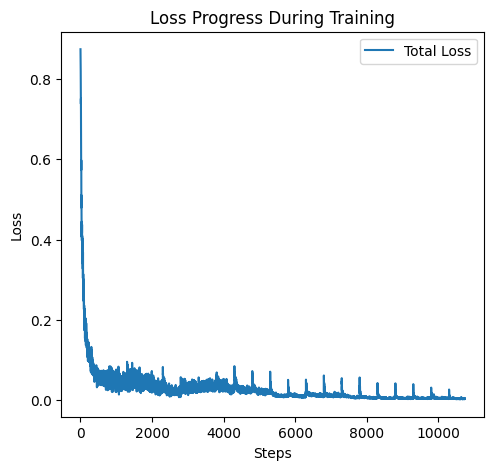

In [ ]:
train_agent(world, num_train_episodes)

### Testing Model
The agent will be tested for a given number of tests. The total manhattan distance between initial location of agent, random location A and B will be used as the metrics to identify the shortest path. We have generated all possible combinations of coordinate of agent, A and B as our test cases. For each test, the number of steps the agent took will be compared to the shortest path to see optimality.

In [ ]:
def test_agent(grid_world: ABSingleAgentGridWorld) -> None:
    steps_per_test = []  # Store the number of steps for each test
    optimal_costs = []
    num_tests = 0
    n = grid_world.n
    failed = 0

    grid_world.activate_testing_mode()

    for x1 in range(n):
        for y1 in range(n):
            for x2 in range(n):
                for y2 in range(n):
                    for x3 in range(n):
                        for y3 in range(n):
                            if x2 == x3 and y2 == y3:
                                break # location a and location b cannot be the same
                            grid_world.reset(agent_location=Coordinate(x1, y1), location_a=Coordinate(x2, y2), location_b=Coordinate(x3,y3))
                            step_count = 0
                            q_values = []
                            path = []

                            # optimal cost to from agent initial location to A to B
                            optimal_costs.append(manhattan(grid_world.agent.location, grid_world.location_a) + manhattan(grid_world.location_a, grid_world.location_b))

                            grid_world.agent.q_learning.epsilon = 0
                            while not grid_world.agent.objective_completed and step_count < 100:
                                action = grid_world.agent.get_action()
                                grid_world.agent.execute_action(action)
                                step_count += 1
                                path.append(grid_world.agent.location)
                            if (step_count >= 100):
                                failed += 1
                                print(f"Agent Initial Location: {x1, y1}")
                                print(f"Location A: {x2, y2}")
                                print(f"Location B: {x3, y3}")
                                print(path)
                            steps_per_test.append(step_count)  # Record the number of steps

    num_tests = len(steps_per_test)

    # Plot for optimal and actual steps
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(num_tests), steps_per_test, label='Steps')
    plt.plot(range(num_tests), optimal_costs, linestyle="dashed", label='Optimal Steps')
    plt.xlabel('Test Number')
    plt.ylabel('Steps')
    plt.title('Step Progress During Testing')
    plt.legend()

    # Plot for difference in optimal and actual steps
    difference = [s-o for s,o in zip(steps_per_test, optimal_costs)]
    print(f"{difference.count(0)}/{num_tests} tests were optimal")
    print(f"{sum(1 for x in difference if x != 0)}/{num_tests} tests were not optimal")
    print(f"{failed}/{num_tests} tests have timed-out")
    plt.subplot(1, 2, 2)
    plt.plot(range(num_tests), difference, label='Steps Difference')
    plt.xlabel('Test Number')
    plt.ylabel('Steps')
    plt.title('Difference in Optimal and Actual Steps During Testing')
    plt.legend()
    plt.show()

3456/3456 tests were optimal
0/3456 tests were not optimal
0/3456 tests have timed-out


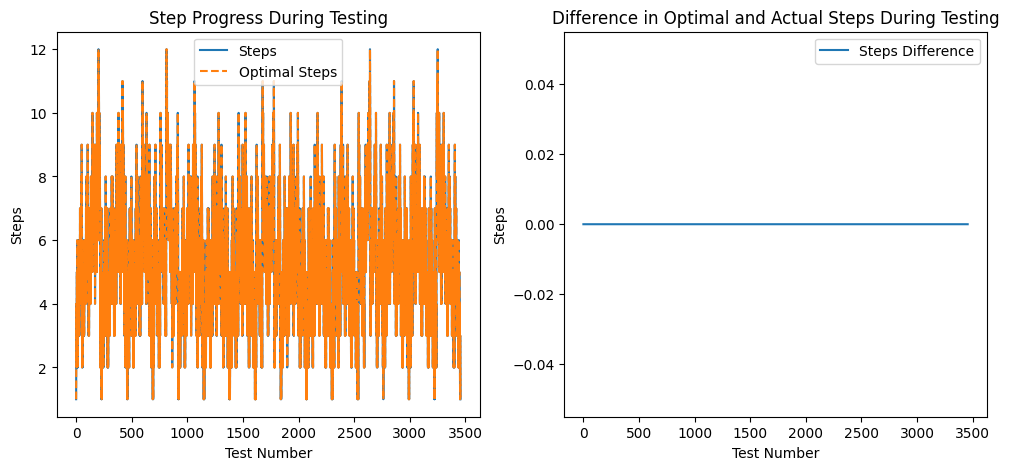

In [ ]:
test_agent(world)


### Testing Observations
The first graph visualises the number of actual steps and the optimal steps measured by manhattan distance of all of our test cases. It is clear that the actual steps taken by the DeepQ agent completely overlaps with the optimal steps of all the possible combination of random location of agent, A and B. The second evidence where the agent has converged is shown from the step difference between the optimal and actual steps of all the test cases, plotted in the second graph. Thus, we can conclude that the agent has indeed converged to the optimal policy